Здесь надо привести нормализованные данные к входам дерева и обучиться на этих данных.

Для этого может потребоваться настройка параметров для фильтров, выбор фильтров, настройка агрегации и т.п, поэтому отдельно не выношу.

In [1]:
import pandas
import numpy
from scipy.signal import iirfilter, lfilter

tick = 25000
window = 128
slide = 0.5


In [8]:
import numpy as np

# signal processing for input batch
fs = 1000000 / tick
filter_N = 4
filter_freq = 10

fft_ac_len = int(window * filter_freq / fs)
fft_gy_len = fft_ac_len


# noice reduction can be performed optimized on all input (but not only on window), no difference in implementation
def reduce_noice(acDf: pandas.DataFrame, gyDf: pandas.DataFrame):
    b, a = iirfilter(filter_N, Wn=filter_freq, fs=fs, btype="low", ftype="butter")

    acX = lfilter(b, a, acDf.x)
    acY = lfilter(b, a, acDf.y)
    acZ = lfilter(b, a, acDf.z)

    gyX = lfilter(b, a, gyDf.x)
    gyY = lfilter(b, a, gyDf.y)
    gyZ = lfilter(b, a, gyDf.z)

    acDf1 = acDf.copy()
    gyDf1 = gyDf.copy()
    
    acDf1["x"] = acX
    acDf1["y"] = acY
    acDf1["z"] = acZ

    gyDf1["x"] = gyX
    gyDf1["y"] = gyY
    gyDf1["z"] = gyZ

    return (acDf1, gyDf1)
    # acil = (acXil**2 + acYil**2 + acZil**2) ** 0.5
    # gyil = (gyXil**2 + gyYil**2 + gyZil**2) ** 0.5


def feature_names():
    def array_names(array_len, label_prefix):
        return list(map(lambda x: f"{label_prefix}_{x}", range(0, array_len)))
    
    return array_names(fft_ac_len, 'acc') + array_names(fft_gy_len, 'gy') + ['acc_max', 'gy_max', 'speed']

# compute magnitude on all axis, apply fast fft transformation, 
# get 32 elements of each (accelerometer, gyroscope), max acceleromet, max gyroscope
def extract_features(acDf: pandas.DataFrame, gyDf: pandas.DataFrame, gpsDf: pandas.Series):
    acM = (acDf["x"] ** 2 + acDf["y"] ** 2 + acDf["z"] ** 2) ** 0.5
    gyM = (gyDf["x"] ** 2 + gyDf["y"] ** 2 + gyDf["z"] ** 2) ** 0.5
    maxAc = max(acM)
    maxGy = max(gyM)

    acFft = np.fft.fft(acM)
    gyFft = np.fft.fft(gyM)
    # frequencies = np.fft.fftfreq(window, 1/fs)

    return np.concatenate([np.abs(acFft[:fft_ac_len]), np.abs(gyFft[:fft_gy_len]), [maxAc, maxGy, gpsDf['speed']]])



In [9]:
# reduce noice, extract features (with fft), write
import matplotlib.pyplot as plt
import pandas as pd
import os
import json

raw_dir = "data/pvs-points/raw"
output_dir = "data/pvs-cart"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)


entry_fpaths = [os.path.join(raw_dir, x) for x in os.listdir(raw_dir)]
out_file = os.path.join(output_dir, "features-predictions.csv")

def read_entry(entry_fpath):
  with open(entry_fpath) as file:
      data = json.load(file)
      acDf = pd.DataFrame.from_records(data["accelerometer"])
      gyDf = pd.DataFrame.from_records(data["gyroscope"])
      gpsDf = pd.Series(data["gps"])
      prediction = data["prediction"]
      return (acDf, gyDf, gpsDf, prediction)

def display_sensors(acDf, gyDf):
  plt.figure().set_figwidth(20)
  plt.plot(range(0, len(acDf)), acDf["x"].to_numpy(), '-', label="AC")
  plt.plot(range(0, len(gyDf)), gyDf["x"].to_numpy(), '-', label="GY")

def display_features(features):
  plt.figure().set_figwidth(20)
  plt.plot(range(0, len(features)), features)

features_predictions = []

for entry_fpath in entry_fpaths:
    acDf, gyDf, gpsDf, prediction = read_entry(entry_fpath)
    acDfn, gyDfn = reduce_noice(acDf, gyDf)
    features = extract_features(acDf, gyDf, gpsDf)
    features_predictions.append(np.concatenate([features, [prediction]]))
    # if prediction == 0.5:
    #   display_sensors(acDfn, gyDfn)
    #   display_features(features)
    #   print(features)
    #   break
    
features_prediction_df = pd.DataFrame(features_predictions, columns=(feature_names() + ['prediction']))
features_prediction_df.to_csv(out_file, index=False)

In [10]:
# select only featues with least correlation
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

features_prediction_df = pd.read_csv(out_file)

corr_matrix = features_prediction_df.corr()
corr_with_prediction = corr_matrix['prediction']


correlations = corr_with_prediction.abs().sort_values(ascending=False)

# select only top k features excluding features
k = 24
exclude_features = ["speed"]

postfix = "-".join(map(lambda x: f"no{x}", exclude_features))
if len(postfix) > 0:
  postfix = "-" + postfix
            
selected_feature_indexes = correlations.drop(['prediction', *exclude_features])[:k].index

out_features_predictions_selected_fpath = os.path.join(output_dir, f"selected-features-predictions-{k}{postfix}.csv")
features_prediction_df_selected = features_prediction_df[[*selected_feature_indexes, 'prediction']]
features_prediction_df_selected.to_csv(out_features_predictions_selected_fpath, index=False)

# save indexes and names of selected features
with open(os.path.join("model", f"selected-features-{k}{postfix}.json"), "w") as file:
  lst = list(map(lambda x: list(features_prediction_df.columns).index(x), selected_feature_indexes))
  json.dump(lst, file)
  print(lst)

with open(os.path.join("model", f"selected-features-names-{k}{postfix}.json"), "w") as file:
  lst = list(selected_feature_indexes)
  json.dump(lst, file)
  print(lst)


[0, 64, 65, 32, 46, 43, 44, 42, 6, 11, 47, 45, 14, 7, 50, 40, 8, 9, 41, 10, 16, 49, 12, 13]
['acc_0', 'acc_max', 'gy_max', 'gy_0', 'gy_14', 'gy_11', 'gy_12', 'gy_10', 'acc_6', 'acc_11', 'gy_15', 'gy_13', 'acc_14', 'acc_7', 'gy_18', 'gy_8', 'acc_8', 'acc_9', 'gy_9', 'acc_10', 'acc_16', 'gy_17', 'acc_12', 'acc_13']


In [11]:
from sklearn import tree
from sklearn.tree import export_graphviz, export_text
from sklearn.model_selection import train_test_split

data = pd.read_csv(out_features_predictions_selected_fpath)
clf = tree.DecisionTreeRegressor(criterion='squared_error', max_depth=5, min_samples_split=2, min_samples_leaf=1)

data_shuffled = features_prediction_df_selected.sample(frac=1, random_state=42)

X = data_shuffled.drop(['prediction'], axis=1)
y = data_shuffled['prediction']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = clf.fit(X_train.values, y_train)

In [12]:
tree_text_path = os.path.join(output_dir, "tree-cart.txt")
tree_graphviz_path = os.path.join(output_dir, "tree-cart.dot")

with open(tree_text_path, "w") as file:
  file.write(export_text(clf))

with open(tree_graphviz_path, "w") as file:
  file.write(export_graphviz(clf))

In [16]:
import pickle

model_dir = "model"

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

with open(os.path.join(model_dir, f"tree-cart-features-{k}{postfix}.pickle"), "wb") as file:
    pickle.dump(clf, file)

In [17]:
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics

def regression_results(y_pred, y_true):
    # Regression metrics
    r2=metrics.r2_score(y_true, y_pred)
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)

    print('R2: ', round(r2,4)) 
    print('Explained variance (biased): ', round(explained_variance,4)) # if mean(error)=0, then R2 = explained variance score
    print('MSE: ', round(mse,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    print('MSLE: ', round(mean_squared_log_error,4)) # mean squared logarithmic error

def visualize_sorted_results(y_pred: numpy.array, y_true: numpy.array):
    y_true_ids = y_true.argsort()
    y_true_sorted = y_true[y_true_ids[::-1]]
    y_pred_sorted = y_pred[y_true_ids[::-1]]
    l = len(y_true_sorted)

    plt.figure().set_figwidth(15)
    plt.scatter(range(0, l), y_true_sorted, label="True", s=5)
    plt.scatter(range(0, l), y_pred_sorted, label="Predicted", s=1)

def distribution_results(y_pred: numpy.array, y_true: numpy.array):
    total = 10
    step = 1 / total
    for i in range(0, total + 1):
        lower_bound = i * step
        upper_bound = (i + 1) * step
        y_true_mask = (y_true >= lower_bound) & (y_true < upper_bound)
        y_pred_dist = [0] * total
        for j in range(0, len(y_true)):
            if y_true_mask[j] == False:
                continue
            bucket = int((y_pred[j] - 0.001) / step)
            y_pred_dist[bucket] += 1

        cnt = y_true_mask.sum()
        if cnt != 0:
            rounded_distribution = [round(v/cnt, 3) for v in y_pred_dist]
            print(f"[{round(lower_bound,2)}...{round(upper_bound, 2)}]={cnt}:\t{'/'.join(map(str, rounded_distribution))}")


R2:  0.6689
Explained variance (biased):  0.6698
MSE:  0.0441
MAE:  0.1417
RMSE:  0.21
MSLE:  0.025
[0.0...0.1]=665:	0.006/0.044/0.092/0.701/0.117/0.002/0.008/0.0/0.003/0.029
[0.1...0.2]=48:	0.0/0.021/0.062/0.75/0.083/0.0/0.021/0.0/0.042/0.021
[0.2...0.3]=43:	0.0/0.07/0.023/0.744/0.14/0.0/0.023/0.0/0.0/0.0
[0.3...0.4]=49:	0.0/0.061/0.061/0.653/0.184/0.0/0.02/0.0/0.02/0.0
[0.4...0.5]=57:	0.018/0.053/0.105/0.667/0.105/0.0/0.018/0.0/0.018/0.018
[0.5...0.6]=1437:	0.0/0.009/0.058/0.743/0.136/0.001/0.017/0.0/0.01/0.026
[0.6...0.7]=18:	0.0/0.056/0.0/0.167/0.222/0.0/0.167/0.0/0.0/0.389
[0.7...0.8]=15:	0.0/0.0/0.0/0.067/0.267/0.0/0.067/0.0/0.0/0.6
[0.8...0.9]=18:	0.0/0.0/0.0/0.0/0.056/0.0/0.111/0.0/0.111/0.722
[0.9...1.0]=7:	0.0/0.0/0.0/0.143/0.0/0.0/0.143/0.0/0.143/0.571
[1.0...1.1]=1640:	0.001/0.002/0.001/0.008/0.026/0.002/0.011/0.001/0.034/0.915


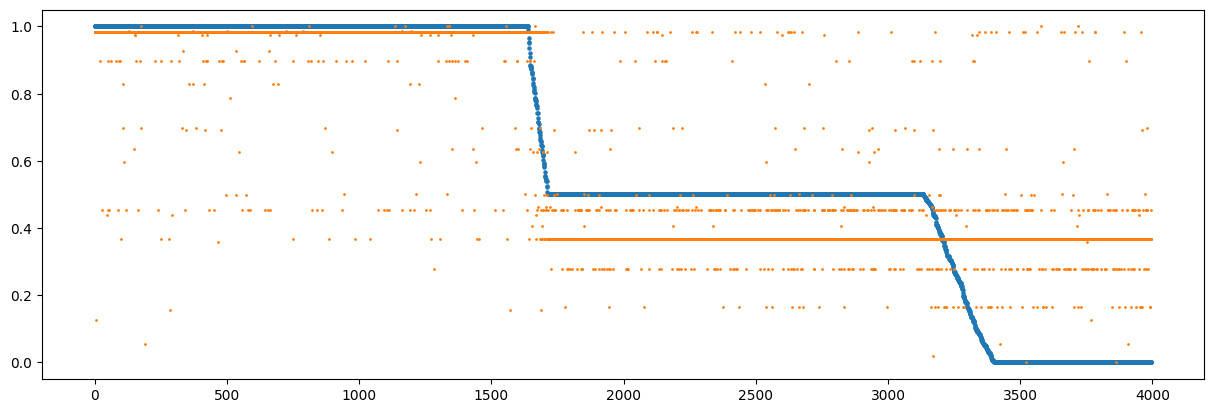

In [18]:
with open(os.path.join(model_dir, f"tree-cart-features-{k}{postfix}.pickle"), "rb") as file:
  clf = pickle.load(file)
  y_predicted = clf.predict(X_test.values)

  regression_results(y_predicted, y_test.to_numpy())
  visualize_sorted_results(y_predicted, y_test.to_numpy())
  distribution_results(y_predicted, y_test.to_numpy())